---
layout: default
title: "Deep Learning - CNN - Sequence models"
categories: deeplearning
permalink: /ML43/
order: 43
comments: true
---

In [2]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["mathtext.fontset"] = "cm"
from matplotlib.patches import Rectangle, Circle

Populating the interactive namespace from numpy and matplotlib


# Sequence Models 
Models like Recurrent Neural Networks (RNNs) have transformed many fields, as for example speech recognition and natural language processing. There are a lot of different types of sequence problems that can be treated as supervised learning problems:

* In speech recognition an input audio source $x$ is mapped to an output text $y$. Both the input and the output are sequence data, because $x$ plays over time and $y$ is a sequence of words.
* In music generation the output $y$ is a sequence, while the input can be void or it may be a single number encoding for the genre or style of music to generated. 
* In sentiment classification the input $x$ is one or more sentences (sequence) while the output $y$ is a number encoding for the quality of the object to which the input refers. 
* Sequence models are also widely used in DNA sequence analysis.
* In machine translation the input $x$ is a sentence that is translated in another output sentence $y$
* In video activity recognition an activity $y$ is recognized from a sequence of video frames $x$
* In name entity recognition entities $y$ like for example peoples are detected in an input sentence $x$

## Notation
Suppose you want a sequence model that extract character names from a sentence $x$ and classifies each word as character name (1) or not (0). This is an example of **Natural Language Processing**.

> $x$: ```Rand is a friend of Perrin and they both live in the twin rivers```<br>
$y$:   ```1    0  0 0      0  1      0   0    0    0    0  0   0    0     ```

The input is a sequence of 13 words ($T_x=13$). They are represented by a set of 13 features to which we will refer as $x^{\langle 1 \rangle}, \dots ,x^{\langle 13 \rangle}$ or more in general they will be referred to as $x^{\langle t \rangle}$ where $t$ implies that they are temporal sequences regardless whether the sequence is temporal or not.

Similarly we refer to $y^{\langle 1 \rangle}, \dots , y^{\langle t \rangle} , \dots,y^{\langle 13 \rangle}$ which has length $T_y$. In this example $T_x = T_y = 13$ but they can be different.

Each training example $X^{(i)}$ has a label associated to some features $t$. To refer to feature $t$ of training example $i$ we use $X^{(i)\langle t \rangle}$. Each training example might have a different number of input features $T_x$. To refer to the number of input features of training example $i$ we use $T_x^{(i)}$. Similarly $y^{(i)\langle t \rangle}$ refers to the $t$-th element in the output sequence of the $i$-th training example and $T_y^{(i)}$ refers to the length of the output sequence in the $i$-the training example.

The representation of individual words $x^{\langle 1 \rangle}$ is based on a vocabulary (or dictionary) $V$, a set of all the words that can be used in a representation. Once a dictionary is defined, one way to represent a word, called **one-hot** representation, is with a vector of the same size of the dictionary where the only non-zero value is at the index of the word in the vocabulary.

$$
V = 
\begin{bmatrix}
\text{a} \\ \vdots \\ \text{is} \\ \vdots \\ \text{Rand} \\ \vdots \\ \text{zulu}
\end{bmatrix}
\begin{matrix}
1 \\ \vdots \\ 2100 \\ \vdots \\8000 \\ \vdots \\ 10.000
\end{matrix}
\qquad x^{\langle 1 \rangle}=
\begin{bmatrix}
0 \\ \vdots \\ 0 \\ \vdots \\ 1 \\ \vdots \\ 0
\end{bmatrix}
\qquad x^{\langle 2 \rangle}=
\begin{bmatrix}
0 \\ \vdots \\ 1 \\ \vdots \\ 0 \\ \vdots \\ 0
\end{bmatrix}
$$

In this representation $x^{\langle t \rangle}$ is a one-hot vector and the task is given this representation for $x$ to learn a mapping to the target output $y$. This is faced as a supervised learning problem trained on labeled data $(x,y)$.

## Recurrent Neural Network Model
The task defined above is to produce a mapping $x \to y$, where $x$ is a series of $T_x$ one-shot vectors and $y$ is a series of $T_y$ output values. With a regular neural network we would incur in a number of problems:

* Input and outputs can be of different lengths in different examples, while we could 0-pad to a fixed length all inputs this is not a good representation
* A regular neural network doesn't share features learned across different position of text. If a model learns that a word appearing in position 1 is a person's name, it is desirable for the model to learn that the same word at another position is equally a person's name. This is similar to what happens in CNNs, where features learned in one part of the image are generalized to other parts of the image.
* A weight matrix for an input layer of the dimensions of the vocabulary (tens or hundreds of thousands of elements) would imply an enormous amount of parameters.

A RNN has none of these problems: When modelling this data in a recurrent neural network we would take the first word of a sentence $x^{\langle 1 \rangle}$ and feed it into a layer of the RNN. This layer would predict if the first word is a person's name or not, producing the output $y^{\langle 1 \rangle}$. In the second step, the second word $x^{\langle 2 \rangle}$ is passed to the layer together with the activation of the previous step $a^{\langle 1 \rangle}$, to produce $y^{\langle 2 \rangle}$. At each time-step the RNN feeds the input $x^{\langle t \rangle}$ and the activation of the previous time-step $a^{\langle t-1 \rangle}$ to produce a prediction $y^{\langle t \rangle}$. The first layer is usually fed a vector of zeros or random values $a^{\langle 0 \rangle}$.

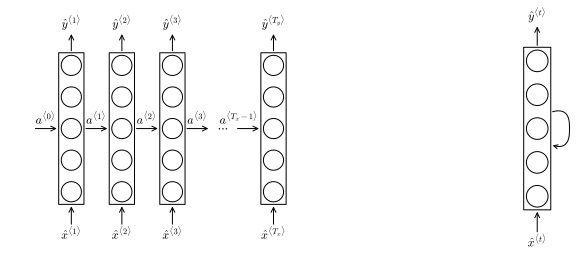

In [303]:
fig, axes = plt.subplots(1,2, figsize=(12 , 4))
ax1, ax2 = axes

def layer(ax, idx, units):
    height = units+1
    r = Rectangle((idx*2, 1), 1, height, fc='none', ec='k')
    for y in  np.linspace(1, height, units):
        ax.add_artist(Circle((idx*2+.5, y+.5), .4, fc='none', ec='k'))
    ax.add_artist(r)
    return r

def io(l, input_lbl, output_lbl, fontsize):
    plt.annotate('$\\hat{{x}}^{{\\langle {} \\rangle}}$'.format(input_lbl), (0.5, 0), (0.5, -0.2), xycoords=l, textcoords=l, 
             arrowprops=dict(arrowstyle='->'), va='center', ha='center', fontsize=fontsize)
    plt.annotate('$\\hat{{y}}^{{\\langle {} \\rangle}}$'.format(output_lbl), (0.5, 1), (0.5, 1.2), xycoords=l, textcoords=l, 
             arrowprops=dict(arrowstyle='<-'), va='center', ha='center', fontsize=fontsize)

def rnn(style, layers, units, shadow_layer=False, fontsize=12, ax=None):

    
    if style=='extended':
        rnn_extended(layers, units, shadow_layer=shadow_layer, fontsize=fontsize, ax=ax)
    elif style=='loopy':
        layers=1
        rnn_loopy(units, fontsize, ax=ax)
    else:
        pass
        
    ax.set_xlim(0, (layers+1)*2)
    ax.set_ylim(0, units+3)
    ax.set_aspect('equal')
    ax.set_axis_off()

def rnn_loopy(units, fontsize, ax=None):
    l = layer(ax, 1, units)
    io(l, 't', 't', fontsize)
    plt.annotate('', (1, 0.4), (1, 0.6), xycoords=l, textcoords=l, va='center', ha='center', 
                 arrowprops=dict(arrowstyle='->',connectionstyle='arc,angleA=20,angleB=160,armA=20,armB=-20,rad=21'))


    
def rnn_extended(layers, units, shadow_layer=False, fontsize=12, ax=None):


    for i in range(1, layers+1):
        xcoords = (-1, 0)
        prev_act = i-1 
        input_lbl = i 
        output_lbl = i
        
        if shadow_layer is True:
            if i == layers-1:
                xcoords= (1, 2)
                ax.text(layers*2-1.5, (units+3)/2, '$\\cdots$', ha='center', va='center', fontsize=fontsize)
            if i == layers:
                prev_act = 'T_x-1'
                input_lbl = 'T_x'
                output_lbl = 'T_y'
        if shadow_layer is False or i != layers - 1:
            l = layer(ax, i, units)
            
            io(l, input_lbl, output_lbl, fontsize)

            
        a = plt.annotate('', (xcoords[0], 0.5), (xcoords[1], 0.5), xycoords=l, textcoords=l, 
         arrowprops=dict(arrowstyle='<-'), va='center', ha='center', fontsize=fontsize)
        plt.annotate('$a^{{\\langle {} \\rangle}}$'.format(prev_act), (0, 0), (1, 1), textcoords=a.arrow_patch, 
             va='bottom', ha='right', fontsize=fontsize)


rnn('extended', 5, 5, shadow_layer=True, ax=ax1)
rnn('loopy', 1, 5, ax=ax2)

<i id="fig:rnn">Representation of a recurrent neural network model. The representation of each element in the input sequence $x^{\langle t \rangle}$ is fed to its layer, which takes as an additional input the activations of the previous layer $a^{\langle t-1 \rangle}$. Each layer produces as output a vector $y^{\langle t \rangle}$</i>.